## 黑盒攻击

### 获取样本迁移
- 利用本项目构建的ResNet进行白盒攻击，将成功攻击的样本迁移再作为黑盒攻击
- 在课程提供的1000个样本基础上，在本项目构建的ResNet上的白盒攻击成功率为15.24%，最佳epsilon为0.001

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from model import CNN

transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('./attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
imgs = transform_test(imgs)
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, attack_model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    perturbed_image.requires_grad_(True)
    perturbed_image.retain_grad()
    attack_target = ((target + 1) % 10)
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            # print('attack failed, gradient is None')
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + epsilon * data_grad.sign()
        
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        with torch.no_grad():
            attack_output = attack_model((perturbed_image.detach() * 0.3530 + 0.2860) * 255)
            if attack_output.max(1, keepdim=True)[1] == attack_target:
                return True, perturbed_image
    print('attack failed, hava reached max iteration')
    return False, perturbed_image

# 定义测试函数
def test(model, attack_model, device, test_loader, epsilon):
    model.eval()
    attack_model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        # img = data.squeeze_(0).squeeze_(0)
        # plt.imshow(img, cmap='gray')
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data.detach())
            attack_output = attack_model((data.detach() * 0.3530 + 0.2860) * 255)
        init_pred = output.max(1, keepdim=True)[1]
        init_attack_pred = attack_output.max(1, keepdim=True)[1]

        # if init_attack_pred.item() != target.item():
            # continue
        # if init_pred.item() != target.item():
            # continue
        correct += 1 # 统计分类正确的图像数量
        if correct % 100 == 0:
            print(f"{correct} of 1000 classified correctly, attack success rate is {success_num / float(correct):.3f}")

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, attack_model=attack_model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))

    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    print(f"Success: {success_num}\tCorrect: {correct}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01, .02, .03, .05, .10, .15, .2, .25, .3]
# 0.001最优
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('./checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)

attack_model = CNN()
attack_model.load_state_dict(torch.load('./model/cnn.ckpt', map_location=device))
attack_model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, attack_model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('./attack_data/black'):
        os.makedirs('./attack_data/black')    
    torch.save(ex, f'./attack_data/black/eps-{eps:.3f}-ASR-{acc:.3f}.pt')

torch.save(examples, './attack_data/black/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.001-0.3")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

### 利用迁移样本攻击

- 攻击样本数据为eps-0.001-ASR-0.152.pt

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
攻击样本数量：
78


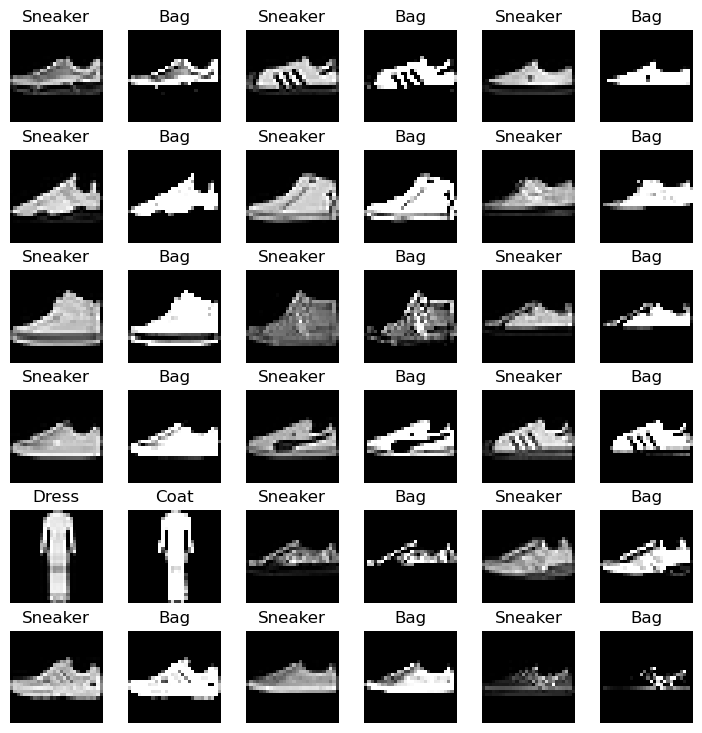

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)
adv_examples = torch.load('./attack_data/black/eps-0.001-ASR-0.078.pt')
print('攻击样本数量：')
print(len(adv_examples))
random.seed(2023)
random.shuffle(adv_examples)

torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target.item()
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'./images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data.cpu().detach().numpy().squeeze(), cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'./images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)